In [18]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json
from scipy.stats import ttest_1samp

# Processing data

In [19]:
rca = pd.read_csv('../../data/results/rca_ensemb.csv')
rca['test_n'] = (rca['train_n'] / 4).astype(int)
rca = rca.query('check =="pass" & test_n > 20')
rca

,embed,norm,train_n,fold,r2,mse,check,test_n
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,1.065544,pass,2167
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,1.047850,pass,2167
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,1.135581,pass,2167
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,1.111463,pass,2167
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,1.171432,pass,2167
...,...,...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,0.710529,pass,125
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,0.844248,pass,125
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,0.862000,pass,125
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,0.919240,pass,125


In [20]:
# Changing category names to custom cat names
meta = pd.read_csv('../../data/psychNorms/psychNorms_metadata.csv', index_col=0)
meta

,description,citation,category,associated_embed,type,n_ratings
norm,,,,,,
Freq_HAL,Log10 version of frequency norms based on the ...,"Lund, K. and C. Burgess (1996). ""Producing hig...",frequency,NaN,numeric,79671
Freq_KF,Log10 version of frequency norms based on the ...,"Kučera, H. and W. N. Francis (1967). Computati...",frequency,NaN,numeric,35230
Freq_SUBTLEXUS,Log10 version of frequency norms based on the ...,"Brysbaert, M. and B. New (2009). ""Moving beyon...",frequency,NaN,numeric,57214
Freq_SUBTLEXUK,Log10 version of the frequency norms based on ...,"Van Heuven, W. J., et al. (2014). ""SUBTLEX-UK:...",frequency,NaN,numeric,61843
Freq_Blog,Log10 version of the frequency norms based on ...,"Gimenes, M. and B. New (2016). ""Worldlex: Twit...",frequency,NaN,numeric,70646
...,...,...,...,...,...,...
familiarity_vanarsdall,Ratings from 1 (highly unfamiliar) to 7 (highl...,"@article{vanarsdall2022analyzing,\n title={An...",familiarity,NaN,numeric,1200
imageability_vanarsdall,Ratings from 1 (low imagery) to 7 (high imagery),"@article{vanarsdall2022analyzing,\n title={An...",imageability,NaN,numeric,1200
familiarity_fear,Ratings from 1 (extremely infrequent) to 7 (ex...,"@article{fear1997ratings,\n title={Ratings fo...",familiarity,NaN,numeric,703


In [21]:
# Adding norm_cat to rca
rca['norm_cat'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca

,embed,norm,train_n,fold,r2,mse,check,test_n,norm_cat
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,1.065544,pass,2167,frequency
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,1.047850,pass,2167,frequency
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,1.135581,pass,2167,frequency
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,1.111463,pass,2167,frequency
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,1.171432,pass,2167,frequency
...,...,...,...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,0.710529,pass,125,imageability
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,0.844248,pass,125,imageability
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,0.862000,pass,125,imageability
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,0.919240,pass,125,imageability


In [22]:
rca_mean = (
    rca[['embed', 'norm', 'r2']].groupby(['embed', 'norm'], as_index=False).mean()
    .rename(columns={'r2': 'r2_mean'})
)
rca_mean

,embed,norm,r2_mean
0,CBOW_GoogleNews,Angry_Binder,0.529488
1,CBOW_GoogleNews,AoA_Glasgow,0.604935
2,CBOW_GoogleNews,AoA_Kuper,0.580193
3,CBOW_GoogleNews,AoA_LWV,0.610645
4,CBOW_GoogleNews,Arousal_Binder,0.553350
...,...,...,...
1445,morphoNLM&PPMI_SVD_SWOW,valence_janschewitz,0.700097
1446,morphoNLM&PPMI_SVD_SWOW,valence_zupan,0.790989
1447,morphoNLM&PPMI_SVD_SWOW,visual_complexity_marrow,0.524038
1448,morphoNLM&PPMI_SVD_SWOW,visual_lyn,0.489210


In [23]:
rca_mean['norm_cat'] = (
    rca_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca_mean

,embed,norm,r2_mean,norm_cat
0,CBOW_GoogleNews,Angry_Binder,0.529488,emotion
1,CBOW_GoogleNews,AoA_Glasgow,0.604935,age of acquisition
2,CBOW_GoogleNews,AoA_Kuper,0.580193,age of acquisition
3,CBOW_GoogleNews,AoA_LWV,0.610645,age of acquisition
4,CBOW_GoogleNews,Arousal_Binder,0.553350,arousal
...,...,...,...,...
1445,morphoNLM&PPMI_SVD_SWOW,valence_janschewitz,0.700097,valence
1446,morphoNLM&PPMI_SVD_SWOW,valence_zupan,0.790989,valence
1447,morphoNLM&PPMI_SVD_SWOW,visual_complexity_marrow,0.524038,sensory
1448,morphoNLM&PPMI_SVD_SWOW,visual_lyn,0.489210,sensory


**Grand avgs**

In [24]:
rca_grand_avg = (
    rca_mean[['embed', 'norm_cat', 'r2_mean']]
    .groupby(['embed', 'norm_cat'], as_index=False).median(numeric_only=True)
    .rename(columns={'r2_mean': 'r2_grand_avg'})
)
rca_grand_avg

,embed,norm_cat,r2_grand_avg
0,CBOW_GoogleNews,age of acquisition,0.471640
1,CBOW_GoogleNews,animacy,0.704477
2,CBOW_GoogleNews,arousal,0.536712
3,CBOW_GoogleNews,associatability,0.252253
4,CBOW_GoogleNews,autidtory lexical decision,0.054738
...,...,...,...
130,morphoNLM&PPMI_SVD_SWOW,social/moral,0.680489
131,morphoNLM&PPMI_SVD_SWOW,space/time/quantity,0.467299
132,morphoNLM&PPMI_SVD_SWOW,this/that,0.516101
133,morphoNLM&PPMI_SVD_SWOW,valence,0.731955


In [25]:
with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
def embed_to_group(embed_name):
    if '&' in embed_name:
        name_1, name_2 = embed_name.split('&')
        return embed_to_type[name_1] + '&' + embed_to_type[name_2]
    else:
        return embed_to_type[embed_name]
    
rca_grand_avg['embed'] = rca_grand_avg['embed'].apply(embed_to_group)
rca_grand_avg = rca_grand_avg.groupby(['embed', 'norm_cat'], as_index=False).mean(numeric_only=True)
rca_grand_avg['norm_cat'] = rca_grand_avg['norm_cat'].str.title()
rca_grand_avg

,embed,norm_cat,r2_grand_avg
0,text,Age Of Acquisition,0.401468
1,text,Animacy,0.601626
2,text,Arousal,0.401454
3,text,Associatability,0.264646
4,text,Autidtory Lexical Decision,0.056970
...,...,...,...
76,text&text,Social/Moral,0.647087
77,text&text,Space/Time/Quantity,0.506645
78,text&text,This/That,0.525242
79,text&text,Valence,0.641902


In [26]:
# Sorts norm_cat by grand avg of text&behavior 
norm_order = (
    rca_grand_avg.query(f'embed == "text&behavior"')
    .sort_values('r2_grand_avg', ascending=True)['norm_cat']
)
rca_grand_avg['norm_cat'] = pd.Categorical(
    rca_grand_avg['norm_cat'], categories=norm_order, ordered=True
)
rca_grand_avg = (
    rca_grand_avg.sort_values('norm_cat', ascending=False).reset_index(drop=True)
)
rca_grand_avg

,embed,norm_cat,r2_grand_avg
0,text&text,Valence,0.641902
1,text,Valence,0.468458
2,text&behavior,Valence,0.747707
3,text&behavior,Concreteness,0.712292
4,text,Concreteness,0.656080
...,...,...,...
76,text,Semantic Decision,0.135697
77,text&behavior,Semantic Decision,0.145147
78,text&text,Autidtory Lexical Decision,0.077352
79,text&behavior,Autidtory Lexical Decision,0.055498


In [27]:
# Top embed_types
sorted_embeds = (
    rca_grand_avg.groupby('embed')['r2_grand_avg']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)
sorted_embeds

,embed,r2_grand_avg
0,text,0.366392
1,text&text,0.466011
2,text&behavior,0.475302


In [28]:
# Pivot table for plotting
rca_grand_avg = (
    rca_grand_avg
    .pivot(index='embed', columns='norm_cat', values='r2_grand_avg')
    .loc[['text', 'text&text', 'text&behavior']]
)
rca_grand_avg

norm_cat,Autidtory Lexical Decision,Semantic Decision,Naming,Number Of Features,Semantic Neighborhood,Familiarity,Visual Lexical Decision,Associatability,Iconicity/Transparency,Recognition Memory,...,Goals/Needs,Semantic Diversity,Arousal,Part Of Speech,Dominance,Animacy,Frequency,Social/Moral,Concreteness,Valence
embed,,,,,,,,,,,,,,,,,,,,,
text,0.056970,0.135697,0.132469,0.131372,0.175448,0.232669,0.217857,0.264646,0.215315,0.348204,...,0.452069,0.545436,0.401454,0.566119,0.358308,0.601626,0.554342,0.459169,0.656080,0.468458
text&text,0.077352,0.143636,0.175222,0.177230,0.237593,0.279185,0.294314,0.305950,0.301505,0.390813,...,0.523287,0.698977,0.550681,0.702934,0.516752,0.710189,0.734983,0.647087,0.746547,0.641902
text&behavior,0.055498,0.145147,0.147631,0.167659,0.229808,0.233494,0.261964,0.310741,0.311794,0.394432,...,0.614158,0.633737,0.634457,0.634670,0.650021,0.687033,0.692610,0.698461,0.712292,0.747707


**grand avg diffs**

In [31]:
# Pivoting to make it easier to compute pairwise differences 
rca_wide = ( 
    rca[['embed', 'norm', 'norm_cat', 'fold', 'r2']]
    .pivot(index=['norm', 'fold', 'norm_cat'], columns='embed', values='r2')
    .reset_index()
)
rca_wide

embed,norm,fold,norm_cat,CBOW_GoogleNews,CBOW_GoogleNews&PPMI_SVD_SWOW,CBOW_GoogleNews&morphoNLM,morphoNLM,morphoNLM&PPMI_SVD_SWOW
0,Angry_Binder,1,emotion,0.451075,0.617672,0.477270,0.497775,0.628661
1,Angry_Binder,2,emotion,0.665392,0.697556,0.660971,0.456568,0.697498
2,Angry_Binder,3,emotion,0.612515,0.637159,0.617868,0.423920,0.653719
3,Angry_Binder,4,emotion,0.546103,0.611599,0.545594,0.225442,0.564086
4,Angry_Binder,5,emotion,0.372354,0.598570,0.434177,0.390407,0.630914
...,...,...,...,...,...,...,...,...
1445,visual_troche,1,sensory,0.774042,0.813851,0.814768,0.692471,0.721595
1446,visual_troche,2,sensory,0.766725,0.726652,0.798349,0.645648,0.651587
1447,visual_troche,3,sensory,0.728824,0.722114,0.720193,0.628234,0.679291
1448,visual_troche,4,sensory,0.806846,0.798616,0.791059,0.645656,0.689450


In [38]:
t_1, t_2 ='CBOW_GoogleNews', 'morphoNLM' # Text
tt = t_1 + '&' + t_2 # Text & Text 
tb_1 = t_1 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 1
tb_2 = t_2 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 2


# Text & Behavior - Text & Text 
rca_wide[f'{tb_1} vs {tt}'] = rca_wide[tb_1] - rca_wide[tt]
rca_wide[f'{tb_2} vs {tt}'] = rca_wide[tb_2] - rca_wide[tt]
tb_vs_tt = (
    rca_wide[['norm', 'norm_cat', f'{tb_1} vs {tt}', f'{tb_2} vs {tt}']]
    .melt(id_vars=['norm', 'norm_cat'])
    .rename(columns={'embed': 'comparing'})
)
tb_vs_tt['comparing'] = 'Text & Behavior - Text & Text'
tb_vs_tt

,norm,norm_cat,comparing,value
0,Angry_Binder,emotion,Text & Behavior - Text & Text,0.140401
1,Angry_Binder,emotion,Text & Behavior - Text & Text,0.036586
2,Angry_Binder,emotion,Text & Behavior - Text & Text,0.019291
3,Angry_Binder,emotion,Text & Behavior - Text & Text,0.066005
4,Angry_Binder,emotion,Text & Behavior - Text & Text,0.164393
...,...,...,...,...
2895,visual_troche,sensory,Text & Behavior - Text & Text,-0.093173
2896,visual_troche,sensory,Text & Behavior - Text & Text,-0.146762
2897,visual_troche,sensory,Text & Behavior - Text & Text,-0.040902
2898,visual_troche,sensory,Text & Behavior - Text & Text,-0.101609


In [ ]:
# Text & Behavior - Text
rca_wide[tb_1 - t_1] = rca_wide[tb_1] - rca_wide[t_1]
rca_wide[tb_1 - t_2] = rca_wide[tb_1] - rca_wide[t_2]

## Plotting 

In [12]:
winner_mask = rca_grand_avg.apply(lambda col: col == col.max(), axis=0)
winner_mask

norm_cat,Autidtory Lexical Decision,Semantic Decision,Naming,Number Of Features,Semantic Neighborhood,Familiarity,Visual Lexical Decision,Associatability,Iconicity/Transparency,Recognition Memory,...,Goals/Needs,Semantic Diversity,Arousal,Part Of Speech,Dominance,Animacy,Frequency,Social/Moral,Concreteness,Valence
embed,,,,,,,,,,,,,,,,,,,,,
text,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
text&text,True,False,True,True,True,True,True,False,False,False,...,False,True,False,True,False,True,True,False,True,False
text&behavior,False,True,False,False,False,False,False,True,True,True,...,True,False,True,False,True,False,False,True,False,True


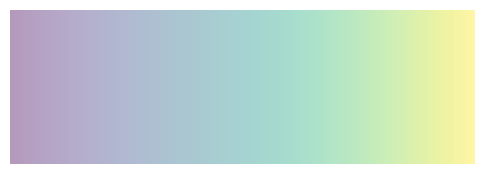

In [13]:
def lighten_cmap(cmap, factor=0.3):
    cmap = plt.cm.get_cmap(cmap, 256)  # Get the original colormap
    colors = cmap(np.linspace(0, 1, 256))

    # Blend each color with white by adjusting RGB values
    white = np.array([1, 1, 1, 1])  # RGBA for white
    new_colors = (1 - factor) * colors + factor * white

    return LinearSegmentedColormap.from_list('lighter_' + cmap.name, new_colors)


def plot_colormap(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_axis_off()
    plt.show()


# Custom colormap: viridis with white added
viridis = plt.cm.get_cmap('viridis', 256)
new_colors = viridis(np.linspace(0, 1, 256))

# Modify the first 30% of the colormap to blend with white
new_colors[:50, :] = [1, 1, 1, 1]  # Setting white for the first 50 values
custom_cmap = LinearSegmentedColormap.from_list('viridis_white', new_colors)

# Generate a lighter version of viridis
lighter_viridis = lighten_cmap('viridis', factor=0.6)  # factor closer to 1 means lighter

# Visualize the lighter viridis colormap
plot_colormap(lighter_viridis)

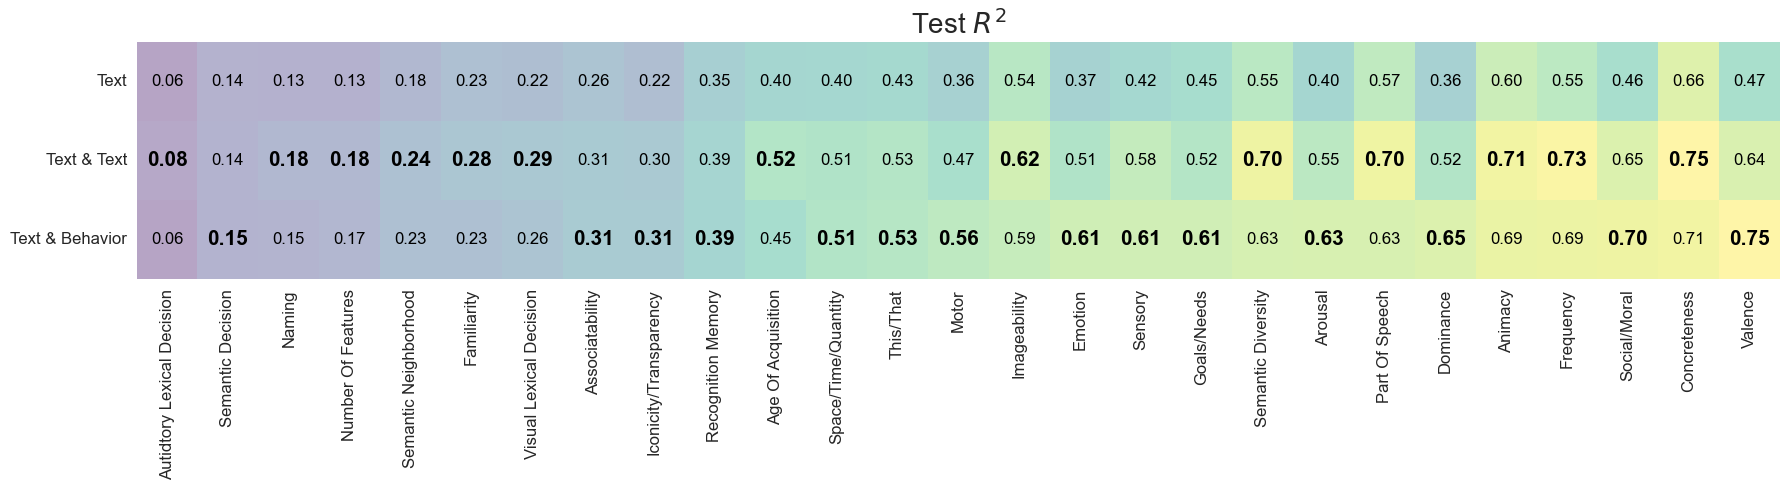

In [15]:
def annotate(heat_df, ax):
    for x, norm_cat in enumerate(heat_df.columns):
        for y, embed in enumerate(heat_df.index):
            annot = heat_df.loc[embed, norm_cat]
            
            # Scientific notation
            if abs(annot) > 1e3:
                annot = f'{annot:.1e}'
            elif np.isnan(annot):
                annot = ''
            else:
                annot = f'{annot:.2f}'
            
            # Fontsize and fontweight
            if winner_mask.loc[embed, norm_cat]:
                fontsize, fontweight = 15, 'bold'
            else:
                fontsize, fontweight = 12, 'normal'
            
            
            ax.text(
                x + .5, y + .5, annot, fontsize=fontsize, fontweight=fontweight,
                ha='center', va='center', color='black'
            )


fig, ax = plt.subplots(1, figsize=(18, 5))

vmax = rca_grand_avg.max().max()
sns.heatmap(
    rca_grand_avg, ax=ax, vmin=0, cmap=lighter_viridis, 
    vmax=vmax, annot=False, fmt='', cbar=False,
    
)

# Removes axis labels
ax.set(xlabel='', ylabel='', yticklabels=['Text', 'Text & Text', 'Text & Behavior'])

# Rotate y-tick labels to be horizontal
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)

# Annotates cells
annotate(rca_grand_avg, ax)

# Sets figure title
ax.set_title('Test $R^2$', fontsize=20)
    
fig.tight_layout()
plt.savefig('../../figures/rca_ensemb.png', dpi=300, bbox_inches='tight')

## Paper Stats
To do: 
1. wilcoxin instead of t? 

In [19]:
np.__version__

'1.26.4'

embed,norm,fold,norm_cat,CBOW_GoogleNews,CBOW_GoogleNews&PPMI_SVD_SWOW,CBOW_GoogleNews&morphoNLM,morphoNLM,morphoNLM&PPMI_SVD_SWOW
0,Angry_Binder,1,emotion,0.451075,0.617672,0.477270,0.497775,0.628661
1,Angry_Binder,2,emotion,0.665392,0.697556,0.660971,0.456568,0.697498
2,Angry_Binder,3,emotion,0.612515,0.637159,0.617868,0.423920,0.653719
3,Angry_Binder,4,emotion,0.546103,0.611599,0.545594,0.225442,0.564086
4,Angry_Binder,5,emotion,0.372354,0.598570,0.434177,0.390407,0.630914
...,...,...,...,...,...,...,...,...
1445,visual_troche,1,sensory,0.774042,0.813851,0.814768,0.692471,0.721595
1446,visual_troche,2,sensory,0.766725,0.726652,0.798349,0.645648,0.651587
1447,visual_troche,3,sensory,0.728824,0.722114,0.720193,0.628234,0.679291
1448,visual_troche,4,sensory,0.806846,0.798616,0.791059,0.645656,0.689450


valence diffs: 


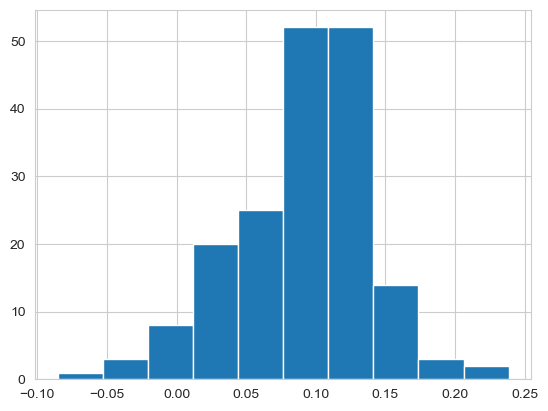

{'cat': 'valence', 'mean': 0.09, 'n': 180, 't': 25.27, 'p': 6.139943003330122e-61}
dominance diffs: 


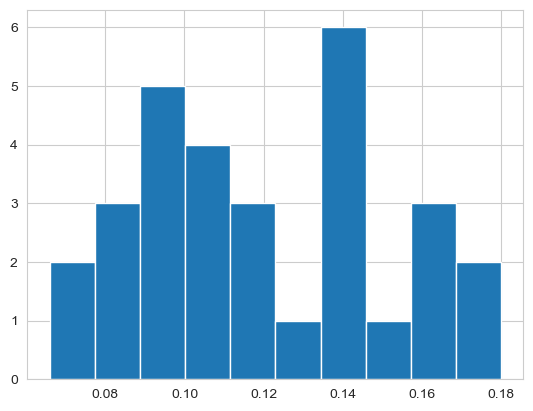

{'cat': 'dominance', 'mean': 0.12, 'n': 30, 't': 20.88, 'p': 5.079343793695236e-19}
arousal diffs: 


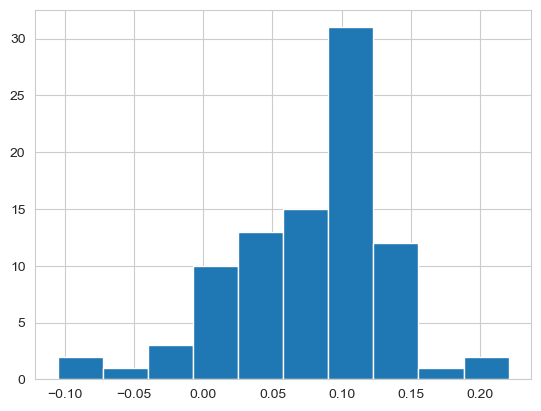

{'cat': 'arousal', 'mean': 0.08, 'n': 90, 't': 13.05, 'p': 2.2502625980251323e-22}
emotion diffs: 


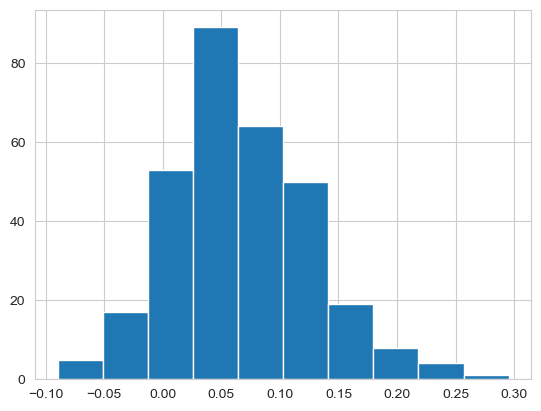

{'cat': 'emotion', 'mean': 0.07, 'n': 310, 't': 19.89, 'p': 2.8534729622503317e-57}
------------------------
goals/needs diffs: 


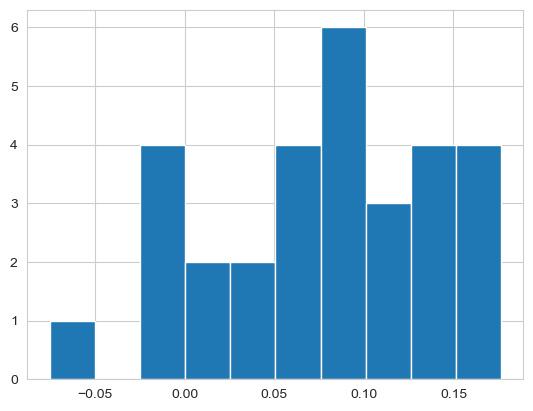

{'cat': 'goals/needs', 'mean': 0.08, 'n': 30, 't': 6.65, 'p': 2.7378322855386877e-07}
motor diffs: 


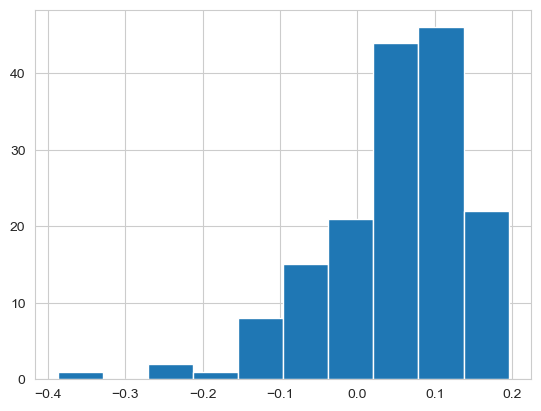

{'cat': 'motor', 'mean': 0.05, 'n': 160, 't': 6.27, 'p': 3.200774268248082e-09}
------------------------
social/moral diffs: 


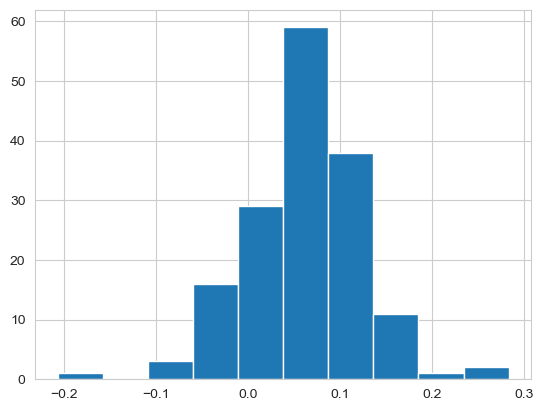

{'cat': 'social/moral', 'mean': 0.06, 'n': 160, 't': 12.13, 'p': 2.1635908003177562e-24}
------------------------
part of speech diffs: 


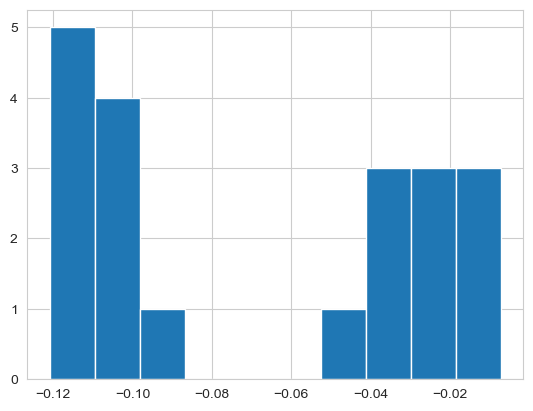

{'cat': 'part of speech', 'mean': -0.07, 'n': 20, 't': -6.91, 'p': 1.3670094933253733e-06}
semantic diversity diffs: 


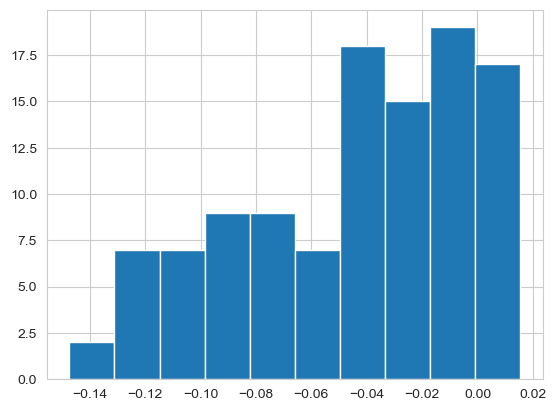

{'cat': 'semantic diversity', 'mean': -0.04, 'n': 110, 't': -11.11, 'p': 1.2702000681113762e-19}
familiarity diffs: 


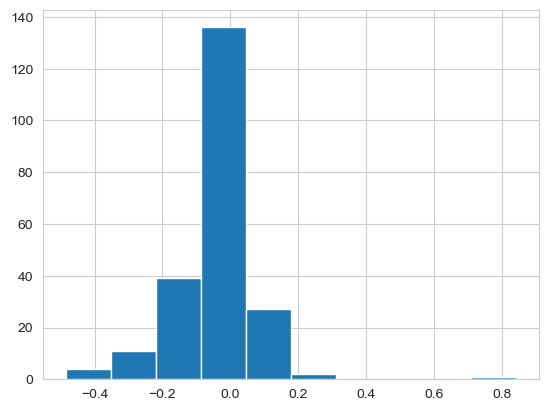

{'cat': 'familiarity', 'mean': -0.05, 'n': 220, 't': -5.79, 'p': 2.413028449008883e-08}


In [17]:
def diff_stats(norm_cat):
    norm_dat = rca_wide.query(f'norm_cat == "{norm_cat}"')
    diffs = pd.concat([
        norm_dat['morphoNLM&PPMI_SVD_SWOW'] - norm_dat['CBOW_GoogleNews&morphoNLM'],
        norm_dat['CBOW_GoogleNews&PPMI_SVD_SWOW'] - norm_dat['CBOW_GoogleNews&morphoNLM'],
    ])
    
    # Printing histogram of diffs
    print(f'{norm_cat} diffs: ')
    diffs.hist()
    plt.show()
    
    
    t, p = ttest_1samp(diffs, 0)
    return {
        'cat': norm_cat, 'mean': diffs.mean().round(2), 
        'n': len(diffs),'t': round(t, 2), 'p': p}

# Text & Behavior > Text & Text
print(diff_stats('valence'))
print(diff_stats('dominance'))
print(diff_stats('arousal'))
print(diff_stats('emotion'))
print('------------------------')
print(diff_stats('goals/needs'))
print(diff_stats('motor'))
print('------------------------')
print(diff_stats('social/moral'))

# Text & Behavior < Text & Text
print('------------------------')
print(diff_stats('part of speech'))
print(diff_stats('semantic diversity'))
print(diff_stats('familiarity'))

In [18]:
valence = rca_wide.query('norm_cat == "valence"')
valence_diffs = pd.concat([
    valence['morphoNLM&PPMI_SVD_SWOW'] - valence['CBOW_GoogleNews&morphoNLM'],
    valence['CBOW_GoogleNews&PPMI_SVD_SWOW'] - valence['CBOW_GoogleNews&morphoNLM'],
])

# scipy t-test for valence
ttest_1samp(valence_diffs, 0)

TtestResult(statistic=25.269566284921364, pvalue=6.139943003330122e-61, df=179)